In [18]:
import json
import pandas as pd
import os
from PIL import Image
from IPython.display import display, Image as IPImage
import google.generativeai as genai
from dotenv import load_dotenv

# 1) Retrieve captions + images for training data

In [51]:
# Load metadata for training data
json_file = "2024_dataset\\train_downloaded.json"
with open(json_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

In [52]:
# Access image and caption data for first entry
if data:
    first_entry = data[0]
    image_id = first_entry["encounter_id"]
    caption = first_entry["responses"][0]["content_en"]
    print(f"Image ID: {image_id}")
    print(f"Caption: {caption}")
else:
    print("The dataset is empty.")

Image ID: 11mk4th
Caption: Most probably it is a case of Milia. A milium is a small cyst containing keratin (the skin protein). Milia do not need to be treated unless they are a cause for concern for the patient. They often clear up by themselves within a few months. Where possible, further trauma should be minimized to reduce the development of new lesions. The lesion may be de-roofed using a sterile needle or blade and the contents squeezed or pricked out.
They may be destroyed using diathermy and curettage, or cryotherapy.


In [ ]:
# Define paths
images_dir = "2024_dataset\\images\\train"
script_path = "2024_dataset\\download_data.py"

In [ ]:
# Combine image paths with captions
data_combined = [
    {
        "image_path": os.path.join(images_dir, f"{entry['encounter_id']}.jpg"),
        "caption": entry["responses"][0]["content_en"],
        "query": entry["query_title_en"]
    }
    for entry in data if os.path.exists(os.path.join(images_dir, f"{entry['encounter_id']}.jpg"))
]

# Convert to df
df = pd.DataFrame(data_combined)
print(df.head())

                              image_path  \
0   2024_dataset\images\train\ih99w9.jpg   
1  2024_dataset\images\train\11n62qx.jpg   
2   2024_dataset\images\train\vk578x.jpg   
3  2024_dataset\images\train\123bko0.jpg   
4  2024_dataset\images\train\11m0l9c.jpg   

                                             caption  \
0  Most probably it is a case of inflamed pimple,...   
1  Most probably it is a case of solar lentigo, a...   
2  Most propably it is a case of a cyst in the gr...   
3  It is a case of common wart. This noncancerous...   
4  Most probably it is a case of deep coarse wrin...   

                                               query  
0  I had this mole that appeared under my eye abo...  
1                                Spot in my hairline  
2  Can someone help me ID this random bump? Today...  
3  Rough bump/spot on the side of finger? What ex...  
4                Puffy line on face any suggestions?  


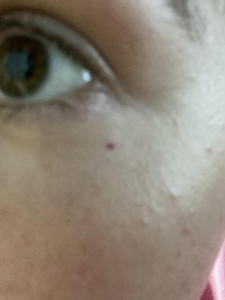

Query: I had this mole that appeared under my eye about 4-5 days ago, and now it’s starting to disappear. The picture I’m showing was taken Friday, I would show you what the “mole” looks like right now but honestly I don’t know how to show two pictures on reddit.
Caption: Most probably it is a case of inflamed pimple, may be due to folliculitis or acne. As it's beginning to disappear you can just wait and follow up if further changes occur. You can also try topical steroid cream for a few days if still inflamed.


In [ ]:
# Display the first image and its caption
first_row = df.iloc[0]
image_path = first_row["image_path"]
caption = first_row["caption"]
query = first_row["query"]

# Open and display the image
img = Image.open(image_path)
img.thumbnail((300, 300))  # Resize to a maximum width and height of 300 pixels
display(img)

# Print the caption
print(f"Query: {query}")
print(f"Caption: {caption}")

# 2) Pass it through an initial baseline architecture

<img src="image.png" alt="image.png" width="300"/>

In [36]:
# Step 1: Load environment variables and configure Gemini
load_dotenv()
api_key = os.getenv('API_KEY')
genai.configure(api_key=api_key)
model = genai.GenerativeModel('gemini-1.5-flash')

QUESTION: is there a med-gemini we can use? https://research.google/blog/advancing-medical-ai-with-med-gemini/

In [37]:
# Step 2: Define a function to process the image with Gemini
def process_image_with_gemini(image_path, model):
    image_prompt = f"""
    Describe the following image in detail for a medical context. Provide a comprehensive description including any visible abnormalities, patterns, or other notable observations.

    Image Path: {image_path}

    Output the description in plain text without any additional formatting.
    """
    response = model.generate_content(image_prompt)
    return response.text.strip()

In [38]:
gemini_description = process_image_with_gemini(image_path, model)

In [39]:
# Print the query, caption, and Gemini description
print(f"Query: {query}")
print(f"Caption: {caption}")
print(f"Gemini Description: {gemini_description}")

Query: I had this mole that appeared under my eye about 4-5 days ago, and now it’s starting to disappear. The picture I’m showing was taken Friday, I would show you what the “mole” looks like right now but honestly I don’t know how to show two pictures on reddit.
Caption: Most probably it is a case of inflamed pimple, may be due to folliculitis or acne. As it's beginning to disappear you can just wait and follow up if further changes occur. You can also try topical steroid cream for a few days if still inflamed.
Gemini Description: The image shows a dermoscopic view of a skin lesion.  The lesion is predominantly brown, with variations in pigmentation ranging from light to dark brown.  There are areas of irregular pigmentation, suggesting possible heterogeneity.  The lesion exhibits a somewhat indistinct border, lacking sharp demarcation from the surrounding skin.  There's a suggestion of possible network-like structures within the lesion, although the resolution may not allow for defin

In [25]:
# Step 3: Combine Gemini's output with the query and generate a response
def generate_response(query, image_description, model):
    response_prompt = f"""
    Based on the following query and image description, provide a detailed and helpful medical response:

    Query: {query}
    Image Description: {image_description}

    Output the response in plain text without any additional formatting.
    """
    response = model.generate_content(response_prompt)
    return response.text.strip()

In [40]:
generated_response = generate_response(query, gemini_description, model)

In [41]:
# Print the query, caption, Gemini description, and generated response
print(f"Query: {query}")
print(f"Caption: {caption}")
print(f"Gemini Description: {gemini_description}")
print(f"Generated Response: {generated_response}")

Query: I had this mole that appeared under my eye about 4-5 days ago, and now it’s starting to disappear. The picture I’m showing was taken Friday, I would show you what the “mole” looks like right now but honestly I don’t know how to show two pictures on reddit.
Caption: Most probably it is a case of inflamed pimple, may be due to folliculitis or acne. As it's beginning to disappear you can just wait and follow up if further changes occur. You can also try topical steroid cream for a few days if still inflamed.
Gemini Description: The image shows a dermoscopic view of a skin lesion.  The lesion is predominantly brown, with variations in pigmentation ranging from light to dark brown.  There are areas of irregular pigmentation, suggesting possible heterogeneity.  The lesion exhibits a somewhat indistinct border, lacking sharp demarcation from the surrounding skin.  There's a suggestion of possible network-like structures within the lesion, although the resolution may not allow for defin

QUESTION: How does the above process compare to simply just having a single prompt where both the image and query are provided to retrieve image description? It seems less confident in its understanding of what it could be from these outputs. What else can we do to improve the quality of the repsonse in addition to changing the process?

In [66]:
# Step 3.5: Filter the dataset for valid image paths
def filter_valid_entries(data, images_dir):
    valid_entries = []
    for entry in data:
        image_path = os.path.normpath(os.path.join(images_dir, f"{entry['encounter_id']}.jpg"))
        if os.path.exists(image_path):  # Check if the image file exists
            valid_entries.append(entry)
        else:
            print(f"Skipping entry with missing image: {entry['encounter_id']}")
    return valid_entries

In [ ]:
# Step 4: Workflow to process an image, query, and caption
def process_entry(entry, images_dir, model):
    # Construct the full image path
    image_path = os.path.normpath(os.path.join(images_dir, f"{entry['encounter_id']}.jpg"))
    
    # Debugging: Print the constructed image path
    print(f"Constructed image path: {image_path}")
    
    # Check if the image exists
    if not os.path.exists(image_path):
        print(f"Image does not exist: {image_path}")
        return None  # Skip entries without an image

    # Extract query and caption
    query = entry.get("query_title_en", "No query provided.")
    original_caption = entry["responses"][0]["content_en"]

    # Process the image with Gemini
    image_description = process_image_with_gemini(image_path, model)

    # Generate a response
    response = generate_response(query, image_description, model)

    # Return the combined data
    return {
        "image_path": image_path,
        "query": query,
        "original_caption": original_caption,
        "image_description": image_description,
        "response": response,
    }

In [ ]:
# Load the JSON data
json_file = "2024_dataset\\train_downloaded.json"
with open(json_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Filter the dataset to only include entries with valid image paths
filtered_data = filter_valid_entries(data, images_dir)

# Process the filtered dataset
if filtered_data:
    # Example: Process only the first valid entry
    first_entry = filtered_data[0]
    processed_entry = process_entry(first_entry, images_dir, model)

    # Debugging: Check the processed entry
    if processed_entry:
        print("Processed Entry:")
        print(processed_entry)
    else:
        print("Processing failed for the first valid entry.")
else:
    print("No valid entries with images were found.")

Skipping entry with missing image: 11mk4th
Skipping entry with missing image: 125gfgg
Skipping entry with missing image: zmsedx
Skipping entry with missing image: 11m079w
Skipping entry with missing image: z8b11d
Skipping entry with missing image: 10t1nag
Skipping entry with missing image: 11zjnov
Skipping entry with missing image: 11luysi
Skipping entry with missing image: 11pdmeh
Skipping entry with missing image: 120abe5
Skipping entry with missing image: 11m5en1
Skipping entry with missing image: 11rbig0
Skipping entry with missing image: 11kbxmx
Skipping entry with missing image: 11e8p16
Skipping entry with missing image: 1246orr
Skipping entry with missing image: 11jxuv5
Skipping entry with missing image: 127afvb
Skipping entry with missing image: 11v4x0x
Skipping entry with missing image: 125745d
Skipping entry with missing image: x9emsm
Skipping entry with missing image: 123um91
Skipping entry with missing image: 11orme3
Skipping entry with missing image: 11qzg8z
Skipping entry

QUESTION: there seem to be guardrails in place - how to prompt engineer this so the output is as meaningful for the patient + similiar to the conference results needed (aka without the guardrails)

In [ ]:
# Step 5: Example Data Processing for all entires in the dataset
def process_dataset(data, images_dir, model):
    results = []
    for entry in data:
        result = process_entry(entry, images_dir, model)
        if result:
            results.append(result)
    return pd.DataFrame(results)

In [ ]:
# Use this code when we are ready to process the entire dataset

# # Load the dataset
# with open('2024_dataset/train_downloaded.json', 'r', encoding='utf-8') as f:
#     data = json.load(f)

# # Define the images directory
# images_dir = "2024_dataset/images/train"

# # Configure the Gemini model
# load_dotenv()
# api_key = os.getenv('API_KEY')
# genai.configure(api_key=api_key)
# model = genai.GenerativeModel('gemini-1.5-flash')

# # Filter valid entries (optional but recommended to avoid missing images)
# data_filtered = [entry for entry in data if os.path.exists(os.path.join(images_dir, f"{entry['encounter_id']}.jpg"))]

# # Process the dataset
# processed_df = process_dataset(data_filtered, images_dir, model)

# # Inspect the output
# print(processed_df.head())

In [ ]:
# Step 6: Display an example in the dataset with side-by-side comparison
def display_example(row):
    # Load and display the image
    img = Image.open(row["image_path"])
    img.thumbnail((300, 300))
    display(img)

    # Print the details
    print(f"Query: {row['query']}\n")
    print(f"Original Caption: {row['original_caption']}\n")
    print(f"Gemini Image Description: {row['image_description']}\n")
    print(f"Generated Response: {row['response']}\n")

In [ ]:
# Use this code when we are ready to process the entire dataset

# # Ensure the DataFrame has been processed
# processed_df = process_dataset(filtered_data, images_dir, model)

# # Check if the DataFrame is not empty
# if not processed_df.empty:
#     # Display the first example in the dataset
#     display_example(processed_df.iloc[0])
# else:
#     print("No valid entries found in the dataset to display.")

QUESTIONS: How can we add in the following: 
- Medical chain-of-thought - see https://arxiv.org/abs/2412.13736v1
- Figure out to map generative text to multiple choice 
- Test out augmenting the queries? or image descriptions? with ShareCaptioner
- Is there a way to extract high- and low-level image features? Taking inspo from Flickr30k dataset..
- What would LLM finetuning look like here? Can we finetune multiple LLMs (region specific) and employ weight-merging or multitask learning?
- Could we leverage multimodal explainability here to provide transparency in model's reasoning? https://jayneelparekh.github.io/LMM_Concept_Explainability